Go directly to:
- [**Start page**](https://github.com/m-guggenmos/remeta/)
- [**Installation**](https://github.com/m-guggenmos/remeta/blob/master/INSTALL.md)
- [**Basic Usage**](https://github.com/m-guggenmos/remeta/blob/master/demo/basic_usage.ipynb)
- [**Common use cases** (this page)](https://github.com/m-guggenmos/remeta/blob/master/demo/common_use_cases.ipynb)
- [**Exotic use cases**](https://github.com/m-guggenmos/remeta/blob/master/demo/exotic_use_cases.ipynb)

## Common use cases

This page introduces some common use cases for the _ReMeta_ toolbox.


[Use case 1: Fit sensory level only](#uc1)

[Use case 2: Simple metacognitive model with a single metacognitive bias](#uc2)

[Use case 3: Default model with multiplicative+additive metacognitive bias parameters](#uc3)

[Use case 4: Noisy-readout model](#uc4)

[Use case 5: Criterion-based link function](#uc5)

In a first step we import the remeta module

In [1]:
%load_ext autoreload
%autoreload 2
import remeta

<a id='uc1'></a>

### Use case 1: Fit sensory level only
With the remeta.load_dataset() method we have access to a couple of simulated datasets. The first dataset is called 'simple'.

In [2]:
stimuli, choices, confidence, params = remeta.load_dataset('simple', return_params=True)

Loading dataset 'simple' which was generated as follows:
..Generative model:
    Metatacognitive noise type: noisy_report
    Metatacognitive noise distribution: truncated_norm
    Link function: probability_correct
..Generative parameters:
    noise_sens: 0.7
    bias_sens: 0.2
    noise_meta: 0.1
    evidence_bias_mult_meta: 1.2
..Characteristics:
    No. subjects: 1
    No. samples: 1000
    Type 1 performance: 78.5%
    Avg. confidence: 0.668
    M-Ratio: 0.921


In [3]:
cfg = remeta.Configuration()
cfg.skip_meta = True
rem = remeta.ReMeta(cfg=cfg)
rem.fit(stimuli, choices, confidence)


+++ Sensory level +++
Initial guess (neg. LL: 1902.65)
    [guess] noise_sens: 0.1
    [guess] bias_sens: 0
Performing local optimization
    [final] noise_sens: 0.745
    [final] bias_sens: 0.24
Final neg. LL: 461.45
Total fitting time: 0.21 secs


We expect a psychometric curve that is shifted to the right due to a positive bias:

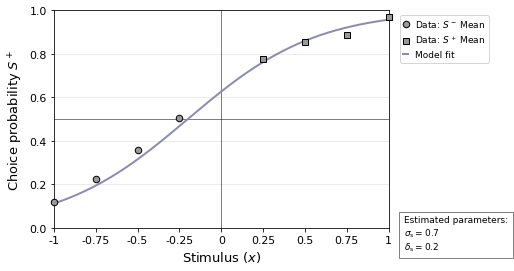

In [4]:
remeta.plot_psychometric(choices, stimuli, params);

In [5]:
# Access results throught the summary method:
result = rem.summary()
# Individual parameters:
for k, v in result.model.params_sens.items():
    print(f'{k}: {v:.3f}')
# Negative log likelihood:
print(f"Neg. LL: {result.model.evidence_sens['negll']:.2f}")
# Akaike Information Criterion (AIC):
print(f"AIC: {result.model.evidence_sens['aic']:.2f}")
# Bayesian Information Criterion (BIC):
print(f"BIC: {result.model.evidence_sens['bic']:.2f}")

noise_sens: 0.745
bias_sens: 0.240
Neg. LL: 461.45
AIC: 926.91
BIC: 936.72


<a id='uc2'></a>

### Use case 2: Simple metacognitive model with a single metacognitive bias
In some cases, it is desirable to have only a single metacognitive bias parameter. In this case, using a multiplicative metacognitive bias parameter may be a good choice due to its clear interpretation, i.e. an under or overestimation of one's own sensory noise. A parameter value > 1 corresponds to underestimating one's sensory noise and thus overconfidence; a parameter value < 1 corresponds to overestimating one's sensory noise and thus underconfidence. In the following we setup such a model.

In [6]:
stimuli, choices, confidence, params, dv_sens = remeta.load_dataset(
    'meta_simple', return_params=True, return_dv_sens=True
)
cfg = remeta.Configuration()
cfg.enable_evidence_bias_add_meta = 0  # enabled by default
rem = remeta.ReMeta(cfg=cfg)

Loading dataset 'meta_simple' which was generated as follows:
..Generative model:
    Metatacognitive noise type: noisy_report
    Metatacognitive noise distribution: truncated_norm
    Link function: probability_correct
..Generative parameters:
    noise_sens: 0.6
    bias_sens: 0
    noise_meta: 0.1
    evidence_bias_mult_meta: 0.8
..Characteristics:
    No. subjects: 1
    No. samples: 1000
    Type 1 performance: 82.6%
    Avg. confidence: 0.588
    M-Ratio: 0.954


Due to the fact that `evidence_bias_mult_meta` is smaller than 1, we have generated data for an underconfident observer.

Let's take a look at the relationship between sensory decison values and confidence:

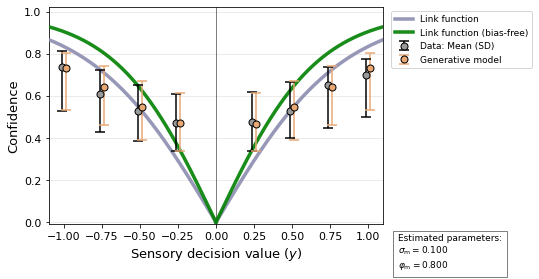

In [7]:
remeta.plot_link_function(stimuli, confidence, dv_sens, params, plot_bias_free=True);

Note that the link function (purple) in the plot is based on the _true parameters_ used to generate the data. The green curve represents an observer without metacognitive biases. In comparison we can recognize the underconfidence of our observer.

Note that metacognitive biases are not parameters of the link function; however, because the link function is a function of metacognitive evidence $z$, but it is here plotted as a function of decision values $y$, biases that act on the transformation $y\rightarrow z$ (these are the _evidence biases_), are nevertheless visible.

Next we fit the model:

In [8]:
rem.fit(stimuli, choices, confidence)


+++ Sensory level +++
Initial guess (neg. LL: 1449.20)
    [guess] noise_sens: 0.1
    [guess] bias_sens: 0
Performing local optimization
    [final] noise_sens: 0.644
    [final] bias_sens: 0.0322
Final neg. LL: 422.29
Total fitting time: 0.45 secs

+++ Metacognitive level +++
Initial guess (neg. LL: 1931.42)
    [guess] noise_meta: 0.2
    [guess] evidence_bias_mult_meta: 1
Grid search activated (grid size = 60)
    [grid] noise_meta: 0.05
    [grid] evidence_bias_mult_meta: 0.8
Grid neg. LL: 1915.0
Grid runtime: 3.20 secs
Performing local optimization
    [final] noise_meta: 0.0807
    [final] evidence_bias_mult_meta: 0.795
Final neg. LL: 1913.12
Total fitting time: 4.6 secs


Note that we can generate the link function plot also directly from the ReMeta instance -- this uses the _fitted parameters_ of the model:

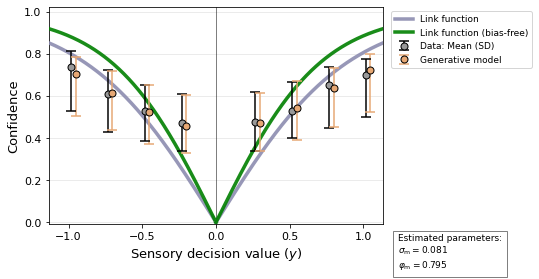

In [9]:
rem.plot_link_function(plot_bias_free=True)

Since the fitted parameters recovered the generative parameters quite well, the plot looks very similar.

As for the sensory level, the summary() method of the _ReMeta_ instance gives access to the parameters and the model evidence of the metacognitive level:

In [10]:
# Access results throught the summary method:
result = rem.summary()
# Individual parameters:
for k, v in result.model.params_meta.items():
    print(f'{k}: {v:.3f}')
# Negative log likelihood:
print(f"Neg. LL: {result.model.evidence_meta['negll']:.2f}")
# Akaike Information Criterion (AIC):
print(f"AIC: {result.model.evidence_meta['aic']:.2f}")
# Bayesian Information Criterion (BIC):
print(f"BIC: {result.model.evidence_meta['bic']:.2f}")

noise_meta: 0.081
evidence_bias_mult_meta: 0.795
Neg. LL: 1913.12
AIC: 3830.23
BIC: 3840.05


<a id='uc3'></a>

### Use case 3: Default model with multiplicative+additive metacognitive bias parameters
By default, the toolbox considers a sensory bias, but no sensory threshold which usually requires more data; at the metacognitive level, the toolbox considers the two metacognitive evidence biases (multiplicative+additive), but no confidence biases. The reason is mainly related to the fact that i) evidence biases have an intuitive explanation (under/overestimation of one's own sensory noise), and ii) confidence biases can lead to flat regions of the evidence-confidence relationship which are difficult for parameter inference.

In this use case we use the default settings. In this case, we do not need to instantiate the Configuration class.

In [11]:
stimuli, choices, confidence, params, dv_sens = remeta.load_dataset(
    'meta', return_params=True, return_dv_sens=True
)
rem = remeta.ReMeta()

Loading dataset 'meta' which was generated as follows:
..Generative model:
    Metatacognitive noise type: noisy_report
    Metatacognitive noise distribution: truncated_norm
    Link function: probability_correct
..Generative parameters:
    noise_sens: 1.4
    bias_sens: -0.1
    noise_meta: 0.1
    evidence_bias_mult_meta: 1.2
    evidence_bias_add_meta: 0.1
..Characteristics:
    No. subjects: 1
    No. samples: 1000
    Type 1 performance: 66.8%
    Avg. confidence: 0.616
    M-Ratio: 0.804


Here, sensory noise is unusually high. We expect a rather flat psychometric curve and a shift towards the left due to the negative sensory bias:

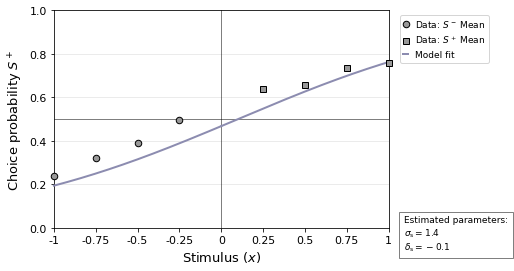

In [12]:
remeta.plot_psychometric(choices, stimuli, params);

Fitting the model:

In [13]:
rem.fit(stimuli, choices, confidence)


+++ Sensory level +++
Initial guess (neg. LL: 3403.57)
    [guess] noise_sens: 0.1
    [guess] bias_sens: 0
Performing local optimization
    [final] noise_sens: 1.57
    [final] bias_sens: 0.12
Final neg. LL: 621.88
Total fitting time: 0.24 secs

+++ Metacognitive level +++
Initial guess (neg. LL: 2232.99)
    [guess] noise_meta: 0.2
    [guess] evidence_bias_mult_meta: 1
Grid search activated (grid size = 60)
    [grid] noise_meta: 0.15
    [grid] evidence_bias_mult_meta: 1.4
Grid neg. LL: 2178.0
Grid runtime: 3.17 secs
Performing local optimization
    [final] noise_meta: 0.164
    [final] evidence_bias_mult_meta: 1.44
Final neg. LL: 2177.76
Total fitting time: 4.5 secs


We see that the recovered parameters deviate a bit more than usual from the generative parameters. This is caused by the high level of sensory noise which also makes inference of other parameters more challenging.

Finally, we take a peak at the link function plot:

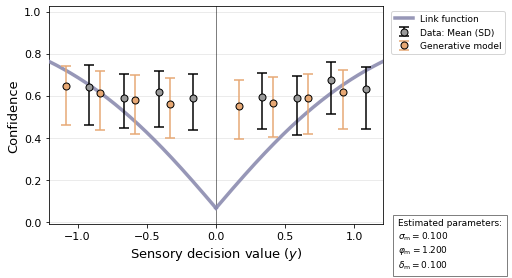

In [14]:
remeta.plot_link_function(stimuli, confidence, dv_sens, params);

<a id='uc4'></a>

### Use case 4: Noisy-readout model
Researchers might have the hypothesis that metacognitive inefficiencies predominate at the level of the readout, e.g. because a theory about a psychiatric condition predicts more noisy metacognitive processing of sensory information. In this case, the data can be fit in noisy-readout mode by setting `meta_noise_type` to `'noisy_readout'`.

In [15]:
stimuli, choices, confidence, params, dv_sens = remeta.load_dataset(
    'noisy_readout', return_params=True, return_dv_sens=True
)

Loading dataset 'noisy_readout' which was generated as follows:
..Generative model:
    Metatacognitive noise type: noisy_readout
    Metatacognitive noise distribution: truncated_norm
    Link function: probability_correct
..Generative parameters:
    noise_sens: 0.4
    bias_sens: 0
    noise_meta: 0.1
    evidence_bias_mult_meta: 0.6
..Characteristics:
    No. subjects: 1
    No. samples: 1000
    Type 1 performance: 90.0%
    Avg. confidence: 0.624
    M-Ratio: 0.880


Here we have a simulated observer with high type 1 performance (90% correct responses) but severe underconfidence (`evidence_bias_mult_meta` is 0.6, where 1 would be no multiplicative bias). Note that the generated data does not include an additive evidence bias (`evidence_bias_add_meta`). 

The underconfidence is reflected in the link function plot:

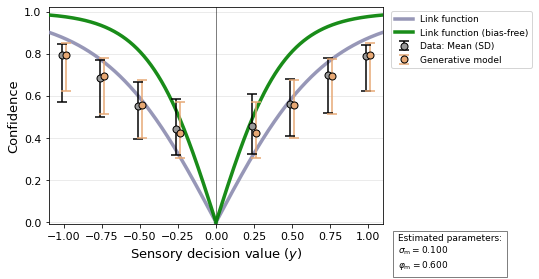

In [16]:
remeta.plot_link_function(stimuli, confidence, dv_sens, params, plot_bias_free=True);

We create a `Configuration` instance and set `meta_noise_type` to `'noisy_readout'`. For the sake of illustration, we use the default model otherwise, which also includes an additive metacognitive evidence bias. We expect it to be zero in the model fit.

In [17]:
cfg = remeta.Configuration()
cfg.meta_noise_type = 'noisy_readout'
rem = remeta.ReMeta(cfg)

In [18]:
rem.fit(stimuli, choices, confidence)


+++ Sensory level +++
Initial guess (neg. LL: 682.87)
    [guess] noise_sens: 0.1
    [guess] bias_sens: 0
Performing local optimization
    [final] noise_sens: 0.41
    [final] bias_sens: 0.0169
Final neg. LL: 274.98
Total fitting time: 0.45 secs

+++ Metacognitive level +++
Initial guess (neg. LL: 1961.65)
    [guess] noise_meta: 0.2
    [guess] evidence_bias_mult_meta: 1
Grid search activated (grid size = 60)
    [grid] noise_meta: 0.15
    [grid] evidence_bias_mult_meta: 0.5
Grid neg. LL: 1676.8
Grid runtime: 4.22 secs
Performing local optimization
    [final] noise_meta: 0.0819
    [final] evidence_bias_mult_meta: 0.59
Final neg. LL: 1649.01
Total fitting time: 6.3 secs


<a id='uc5'></a>

### Use case 5: Criterion-based link function

In [19]:
stimuli, choices, confidence, params, dv_sens = remeta.load_dataset(
    'criteria', return_params=True, return_dv_sens=True
)

Loading dataset 'criteria' which was generated as follows:
..Generative model:
    Metatacognitive noise type: noisy_report
    Metatacognitive noise distribution: truncated_norm
    Link function: 4_criteria
..Generative parameters:
    noise_sens: 0.6
    bias_sens: 0
    noise_meta: 0.1
    criteria_meta: [0.1, 0.25, 0.5, 0.8]
..Characteristics:
    No. subjects: 1
    No. samples: 1000
    Type 1 performance: 82.6%
    Avg. confidence: 0.655
    M-Ratio: 0.953


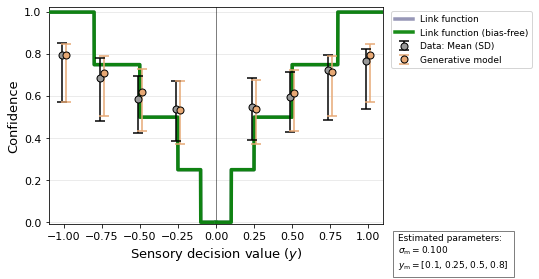

In [20]:
remeta.plot_link_function(stimuli, confidence, dv_sens, params, meta_link_function='4_criteria', plot_bias_free=True);

In [21]:
cfg = remeta.Configuration()
cfg.enable_criteria_meta = 1
cfg.enable_evidence_bias_mult_meta = 0
cfg.enable_evidence_bias_add_meta = 0
cfg.meta_link_function = '4_criteria'
rem = remeta.ReMeta(cfg)

In [22]:
rem.fit(stimuli, choices, confidence)


+++ Sensory level +++
Initial guess (neg. LL: 1449.20)
    [guess] noise_sens: 0.1
    [guess] bias_sens: 0
Performing local optimization
    [final] noise_sens: 0.644
    [final] bias_sens: 0.0322
Final neg. LL: 422.29
Total fitting time: 0.42 secs

+++ Metacognitive level +++
Initial guess (neg. LL: 1899.67)
    [guess] noise_meta: 0.2
    [guess] criterion0_meta: 0.2
    [guess] criterion1_meta: 0.4
    [guess] criterion2_meta: 0.6
    [guess] criterion3_meta: 0.8
Grid search activated (grid size = 700)
    [grid] noise_meta: 0.15
    [grid] criterion0_meta: 0.1
    [grid] criterion1_meta: 0.319
    [grid] criterion2_meta: 0.586
    [grid] criterion3_meta: 0.7407
Grid neg. LL: 1863.3
Grid runtime: 30.32 secs
Performing local optimization
LL Nelder_mead: 1859.391
    [final] noise_meta: 0.131
    [final] criterion0_meta: 0.11
    [final] criterion1_meta: 0.318
    [final] criterion2_meta: 0.568
    [final] criterion3_meta: 0.771
Final neg. LL: 1859.39
Total fitting time: 38 secs


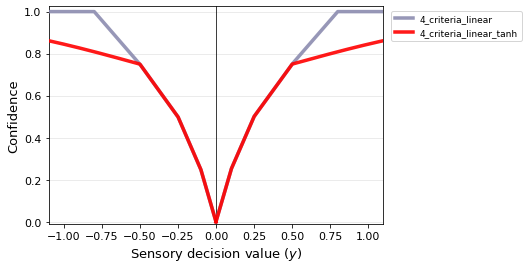

In [23]:
remeta.plot_link_function(stimuli, confidence, dv_sens, params, meta_link_function='4_criteria_linear', 
                          plot_data=False, plot_generative_data=False, display_parameters=False, 
                          label_linkfunction='4_criteria_linear');
remeta.plot_link_function(stimuli, confidence, dv_sens, params, meta_link_function='4_criteria_linear_tanh', 
                          plot_data=False, plot_generative_data=False, display_parameters=False, 
                          color_linkfunction='red', label_linkfunction='4_criteria_linear_tanh');